In [41]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scipy.interpolate import griddata


# section 4.3

In [6]:
data = pd.read_csv('Data/Howell1.csv', sep=';') 

In [8]:
adult_data = data[data['age'] >= 18]

In [9]:
adult_data

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


## prior

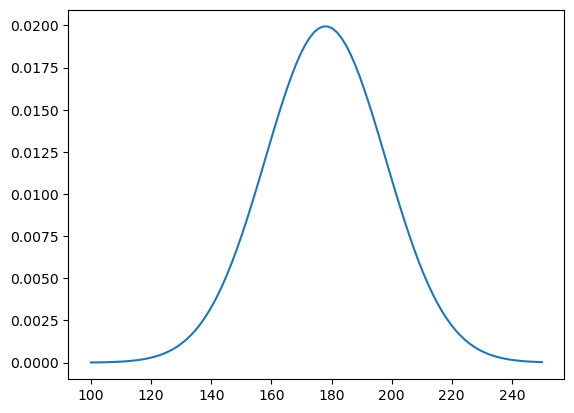

In [81]:
### mu 

x = np.linspace(100, 250, 100)
y = stats.norm.pdf(x, 178, 20)
plt.plot(x, y)
plt.show()

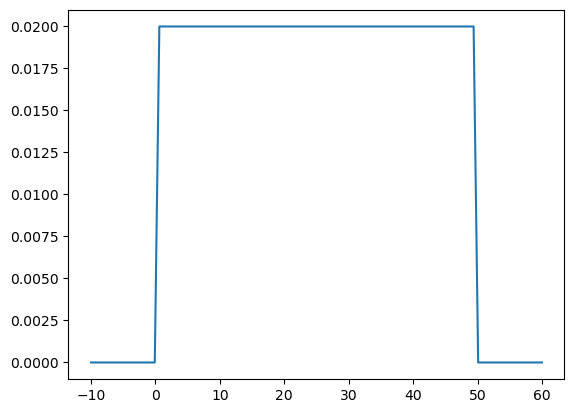

In [201]:
### sigma
x = np.linspace(-10, 60, 100)
y = stats.uniform.pdf(x, 0, 50)
plt.plot(x, y)
plt.show()

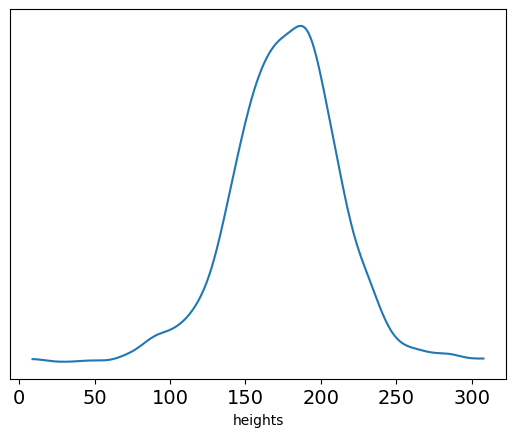

In [83]:
n_samples = 1000

sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([])
plt.show()

## grid approximation 

In [43]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(adult_data.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))

post_prob = np.exp(post_prod - max(post_prod))

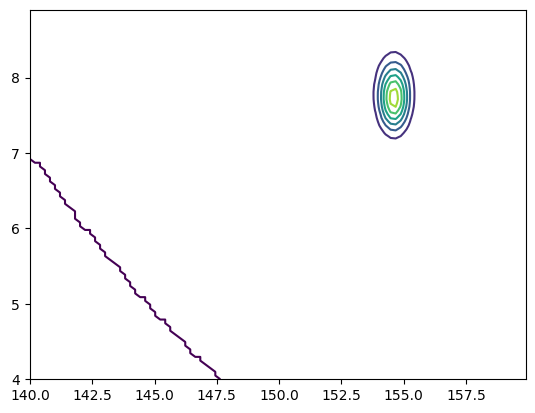

In [84]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi)
plt.show()

## sample from posterior

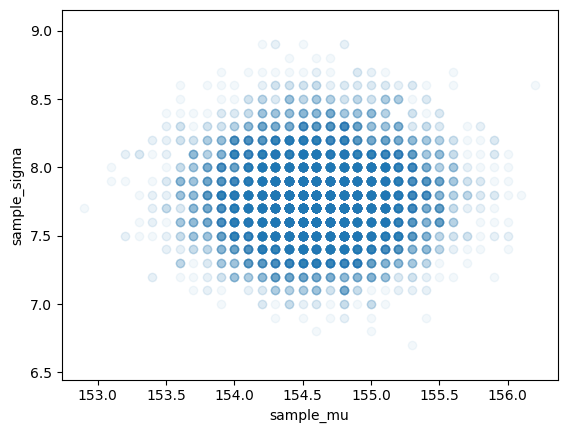

In [85]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))

sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma')
plt.show()

In [48]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.8, 155.3]), array([7.3, 8.4]))

## MAP 

In [58]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=adult_data.height)

In [65]:
with m4_1:
    trace_4_1 = pm.sample(400, tune=1000)

/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 400 draw iterations (4_000 + 1_600 draws total) took 8 seconds.


In [66]:
az.summary(trace_4_1, hdi_prob=0.89).round(2)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,177.86,0.11,177.70,178.04,0.00,0.00,1378.0,1179.0,1.0
sigma,24.63,0.90,23.22,26.07,0.02,0.02,1286.0,1229.0,1.0


In [67]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.011955,0.006966
sigma,0.006966,0.818928


In [68]:
trace_df.corr()

,mu,sigma
mu,1.000000,0.070401
sigma,0.070401,1.000000


In [69]:
trace_df

,mu,sigma
0,177.967107,24.605099
1,177.797365,23.878634
2,177.761248,22.739085
3,177.852486,25.813114
4,177.852486,25.813114
...,...,...
1595,177.898648,24.507939
1596,177.780167,24.889552
1597,177.810263,24.828439
1598,177.870899,27.165363


In [72]:
trace_df

,mu,sigma
0,177.967107,24.605099
1,177.797365,23.878634
2,177.761248,22.739085
3,177.852486,25.813114
4,177.852486,25.813114
...,...,...
1595,177.898648,24.507939
1596,177.780167,24.889552
1597,177.810263,24.828439
1598,177.870899,27.165363


In [73]:
az.summary(trace_4_1, hdi_prob=.89).round(2)


Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,177.86,0.11,177.70,178.04,0.00,0.00,1378.0,1179.0,1.0
sigma,24.63,0.90,23.22,26.07,0.02,0.02,1286.0,1229.0,1.0


# 4.4 

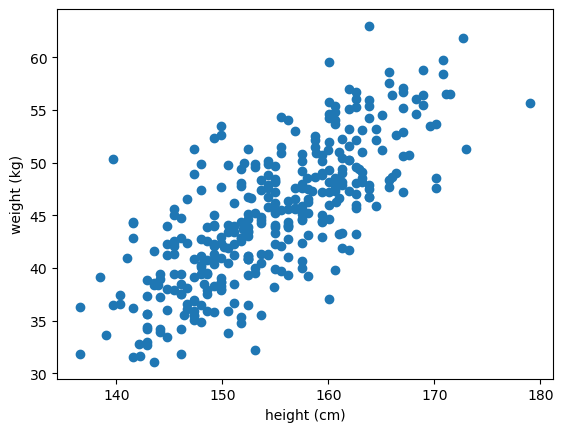

In [80]:
plt.scatter(adult_data.height, adult_data.weight, marker='o')
plt.xlabel('height (cm)')
plt.ylabel('weight (kg)') 
plt.show()

In [94]:
with pm.Model() as m4_3:
    
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    mu = alpha + beta * adult_data.weight

    height = pm.Normal('height', mu=mu, sd=sigma, observed=adult_data.height)
    
    trace_4_3 = pm.sample(1000, tune=1000)

/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [95]:
az.summary(trace_4_3, hdi_prob=0.89).round(2)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,113.82,1.97,110.73,116.92,0.06,0.04,1238.0,1368.0,1.01
beta,0.91,0.04,0.84,0.98,0.00,0.00,1224.0,1348.0,1.00
sigma,5.11,0.19,4.81,5.43,0.00,0.00,1955.0,1648.0,1.00


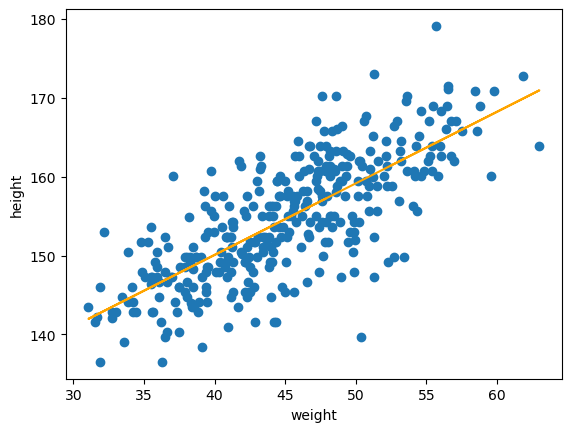

In [100]:
plt.scatter(adult_data.weight, adult_data.height)
plt.plot(adult_data.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * adult_data.weight, color='orange')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

In [167]:
N = [10, 50, 150, 352][3]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * adult_data.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=adult_data.height[:N])
    trace_N = pm.sample(1000, tune=1000)

/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniconda/base/envs/rethinking/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9039258262

In [170]:
chain_N = trace_N

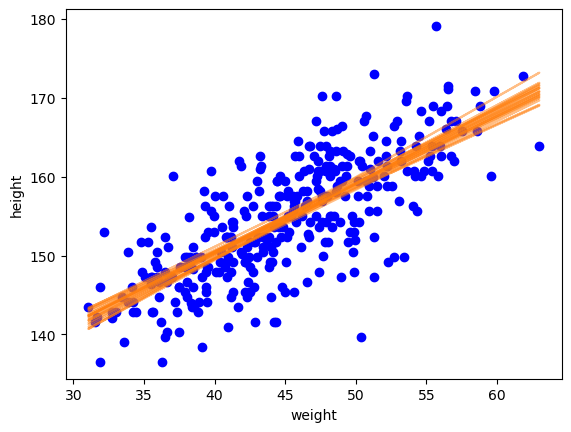

In [171]:
N = 353 

plt.scatter(adult_data.weight[:N], adult_data.height[:N], color='blue')

for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(adult_data.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * adult_data.weight[:N], 'C1-', alpha=0.5)

plt.xlabel('weight')
plt.ylabel('height')
plt.show()


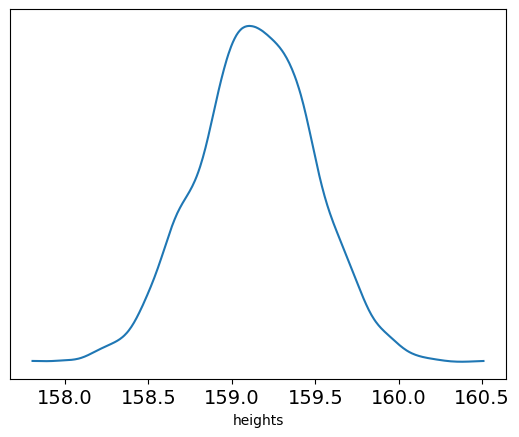

In [172]:
mu_at_50 = chain_N['alpha'] + chain_N['beta'] * 50
az.plot_kde(mu_at_50)
plt.xlabel('heights')
plt.yticks([])
plt.show()

In [173]:
az.hdi(mu_at_50, credible_interval=.89)


array([158.50552506, 159.79089321])

In [175]:
pm.trace_to_dataframe(chain_N)

,alpha,beta,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__342,mu__343,mu__344,mu__345,mu__346,mu__347,mu__348,mu__349,mu__350,mu__351
0,111.458371,0.961756,5.255942,157.454916,146.548799,142.104557,162.471729,151.156634,172.041846,148.239247,...,153.801367,157.509446,149.357124,150.938511,150.720389,156.691488,144.394842,161.626505,163.453280,161.980954
1,117.802442,0.815173,5.171849,156.788599,147.544697,143.777807,161.040794,151.450246,169.152319,148.977502,...,153.691892,156.834819,149.925002,151.265368,151.080490,156.141526,145.719027,160.324392,161.872746,160.624819
2,115.933440,0.861014,5.262771,157.111954,147.348229,143.369510,161.603268,151.473403,170.170938,148.861606,...,153.841106,157.160773,149.862388,151.278128,151.082854,156.428494,145.419893,160.846580,162.482004,161.163901
3,116.376777,0.846386,5.194142,156.855694,147.257848,143.346725,161.270704,151.312938,169.692814,148.745514,...,153.640416,156.903684,149.729293,151.120981,150.929024,156.183845,145.362273,160.526871,162.134510,160.838801
4,116.376777,0.846386,5.194142,156.855694,147.257848,143.346725,161.270704,151.312938,169.692814,148.745514,...,153.640416,156.903684,149.729293,151.120981,150.929024,156.183845,145.362273,160.526871,162.134510,160.838801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,112.148832,0.940688,5.137521,157.137783,146.470575,142.123688,162.044699,150.977471,171.405175,148.123992,...,153.564269,157.191120,149.217381,150.764126,150.550782,156.391079,144.363801,161.217991,163.004748,161.564675
3996,115.099257,0.884258,5.492077,157.389431,147.362122,143.275994,162.001993,151.598660,170.800956,148.916355,...,154.030282,157.439567,149.944154,151.398114,151.197568,156.687519,145.381729,161.224876,162.904450,161.550764
3997,113.189493,0.926165,5.165748,157.483917,146.981386,142.701605,162.315082,151.418706,171.531052,148.609279,...,153.965570,157.536430,149.685788,151.208655,150.998605,156.748740,144.907137,161.501135,163.260309,161.842468
3998,112.965960,0.914860,5.210385,156.719689,146.345361,142.117822,161.491880,150.728515,170.595353,147.953382,...,153.244289,156.771561,149.016750,150.521028,150.313541,155.993486,144.296431,160.687870,162.425570,161.025035


In [186]:
weight_seq = np.arange(25, 71)

chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chain_N.nchains))

for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

In [187]:
mu_pred.shape

(46, 400)

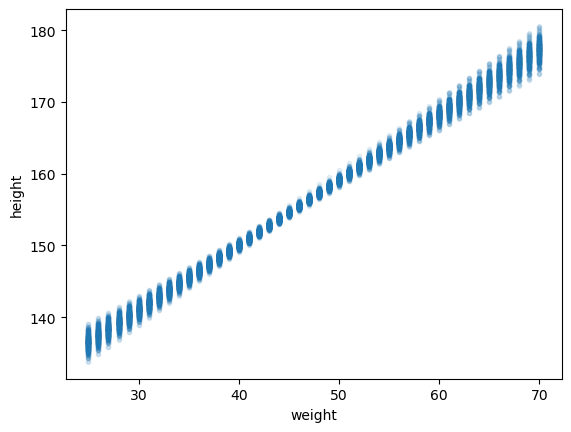

In [193]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

In [200]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hdi(mu_pred.T, hdi_prob=.89)


/var/folders/_w/2ch5hts12q9d9nsstbygh3_r0000gp/T/ipykernel_47192/3738479357.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hpd = az.hdi(mu_pred.T, hdi_prob=.89)
